# Flag-Print-Test
### Ideas

QR-code to get code and details from a git repository

All square flags

Number of colors

Objects / Layout

### Basic imports and global functions

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import colorsys
import os.path
import shutil
from PIL import Image

In [22]:
with open('RGBA_flags.pkl', 'rb') as f:
    flags = pickle.load(f)

with open('filenames.pkl', 'rb') as f:
    filenames = pickle.load(f)

# Eliminate duplicate flags (i.e. French or British flag)
duplicates = [220, 227, 229, 230, 231]
flags = [flags[i] for i in range(len(flags)) if i not in duplicates]
filenames = [filenames[i] for i in range(len(filenames)) if i not in duplicates]

df = pd.read_excel('data_extended.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'data_extended.pkl'

In [3]:
def plot_flags(flags, order=None, orientation='horizontal', rows=1, cols='full', scale=1):
    """
    Plot a list of flags in a given order. The plot grid is fully customizable
    in orientation, shape, and scale.
    """
    if order is None:
        N = len(flags)
        order = np.arange(N)
    else:
        N = min(len(flags), len(order))
    if rows == 'full':
        rows = np.ceil(N / cols).astype(int)
    if cols == 'full':
        cols = np.ceil(N / rows).astype(int)
    if orientation == 'horizontal':
        fig, ax = plt.subplots(rows, cols, figsize=(3*scale*cols, 2*scale*rows))
        ax = ax.reshape((rows, cols))
        for n, flag in enumerate([flags[i] for i in order]):
            ax[n//cols, n%cols].imshow(np.swapaxes(flag, 0, 1))
            ax[n//cols, n%cols].axis('off')
    elif orientation == 'vertical':
        fig, ax = plt.subplots(rows, cols, figsize=(2*scale*cols, 3*scale*rows))
        ax = ax.reshape((rows, cols))
        for n, flag in enumerate([flags[i] for i in order]):
            ax[n//cols, n%cols].imshow(flag)
            ax[n//cols, n%cols].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

### Flag complexities

In [4]:
def complexity(flag):
    """
    Compute the complexity of a flag obtained using the mean absolute change
    of the RGB-values between neighboring pixels in the horizontal and vertical
    direction of the flag.
    """
    num_vrt_pixels = flag.shape[0]
    num_hrz_pixels = flag.shape[1]
    mean_vrt_change = np.mean(np.abs(flag - np.roll(flag, shift=1, axis=0)))
    mean_hrz_change = np.mean(np.abs(flag - np.roll(flag, shift=1, axis=1)))
    return mean_vrt_change*num_vrt_pixels + mean_hrz_change*num_hrz_pixels

complexities = [complexity(flag) for flag in flags]
complexity_ranking = np.argsort(complexities)

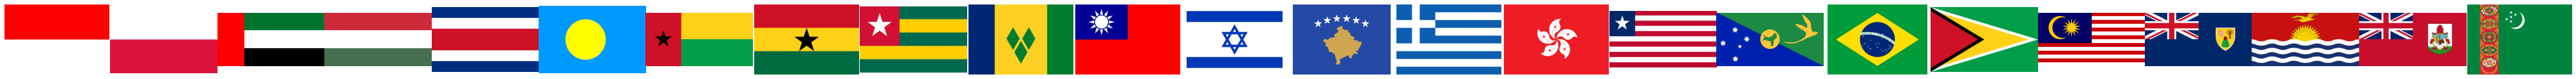

In [5]:
plot_flags(flags, rows=1, order=complexity_ranking[::10])

In [6]:
filenames_sorted = [filenames[i] for i in complexity_ranking]
for i, filename in enumerate(filenames_sorted):
    shutil.copyfile('svg_flags/' + filename + '.svg', 'svg_flags/Complexity/' + str(i) + '_' + filename  + '.svg')

## Flag colors

In [7]:
def extract_colors(flag, min_percent=1e-2):
    """
    Extract all RGB-colors from a flag that make out at least a significant
    percentage of the whole flag. Also returns the percentage each of these
    color makes up and the total number of (significant) colors in the flag.
    """
    flattened = flag.reshape(-1, flag.shape[-1])
    num_pixels = flattened.shape[0]
    colors, counts = np.unique(flattened, axis=0, return_counts=True)
    reduced_colors = colors[counts > num_pixels * min_percent]
    reduced_percentages = counts[counts > num_pixels * min_percent] / num_pixels
    num_colors = len(reduced_percentages)
    return reduced_colors, reduced_percentages, num_colors

dir = '.checkpoints/extract_colors.pkl'
if os.path.isfile(dir):
    with open(dir, 'rb') as f:
        flag_colors, color_percentages, num_colors = pickle.load(f)
else:
    flag_colors, color_percentages, num_colors = zip(*[extract_colors(flag) for flag in flags])
    with open(dir, 'wb') as f:
        pickle.dump((flag_colors, color_percentages, num_colors), f)

In [8]:
def RGB_to_CMYK(RGB):
    """
    Convert an RGB-image (on {0, 1, ..., 255}) into CMYK-scale (on [0, 1]).
    """
    if sum(RGB) == 0:
        return [0., 0., 0., 1.]
    CMY = [1 - rgb / 255 for rgb in RGB]
    k = min(CMY)
    CMYK = [(cmy - k) / (1 - k) for cmy in CMY]
    CMYK.append(k)
    return CMYK

In [9]:
def color_distance(CMYK1, CMYK2):
    """
    Compute the 'distance' two CMYK-colors are away from each other. Distance
    metric is proportional to the L4 metric (weights up larger deviations).
    """
    return (CMYK1[0]-CMYK2[0])**4 + (CMYK1[1]-CMYK2[1])**4 + (CMYK1[2]-CMYK2[2])**4 + (CMYK1[3]-CMYK2[3])**4

In [10]:
CMYK_flag_colors = [[RGB_to_CMYK(color[:3]) for color in colors] for colors in flag_colors]

In [11]:
def get_color_likeness_ranking(CMYK_flag_colors, color_percentages, reference_color):
    """
    Color likeness between CMYK flags and a reference color.
    """
    color_distances = []
    for i, colors in enumerate(CMYK_flag_colors):
        length = len(colors)
        count = 0
        avg_col_dist = 0
        for j, color in enumerate(colors):
            if sum(color) < 0.01:
                continue
            elif color_percentages[i][j] > 0.3:
                count += 1
                avg_col_dist += color_distance(color, reference_color)
        if count == 0:
            avg_col_dist = 4
        color_distances.append(avg_col_dist)
    return np.argsort(color_distances)

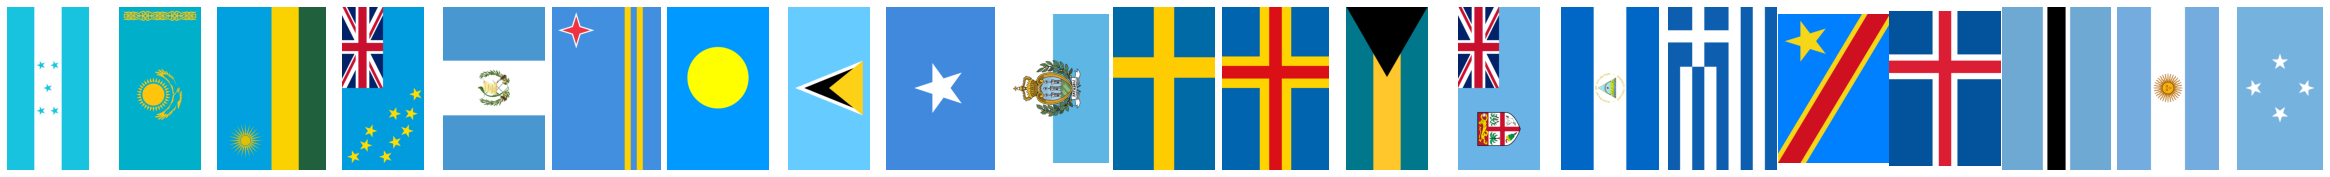

In [12]:
cyan_likeness_ranking = get_color_likeness_ranking(CMYK_flag_colors, color_percentages, [1.0, 0.0, -1.0, 0])
num_cyan_flags = 21
cyan_flags = [flags[i] for i in cyan_likeness_ranking[:num_cyan_flags]]
plot_flags(cyan_flags, rows=1, orientation='vertical')

filenames_sorted = [filenames[i] for i in cyan_likeness_ranking[:num_cyan_flags]]
for i, filename in enumerate(filenames_sorted):
    shutil.copyfile('svg_flags/' + filename + '.svg', 'svg_flags/Color/Cyan/' + str(i) + '_' + filename  + '.svg')

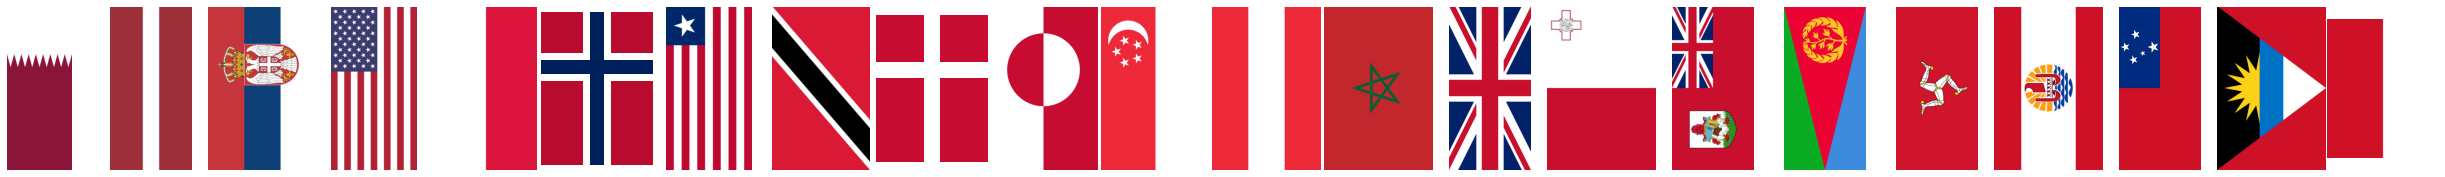

In [13]:
magenta_likeness_ranking = get_color_likeness_ranking(CMYK_flag_colors, color_percentages, [-1.0, 1.0, 0.0, 0])
num_magenta_flags = 22
magenta_flags = [flags[i] for i in magenta_likeness_ranking[:num_magenta_flags]]
plot_flags(magenta_flags, rows=1, orientation='vertical')

filenames_sorted = [filenames[i] for i in magenta_likeness_ranking[:num_magenta_flags]]
for i, filename in enumerate(filenames_sorted):
    shutil.copyfile('svg_flags/' + filename + '.svg', 'svg_flags/Color/Magenta/' + str(i) + '_' + filename  + '.svg')

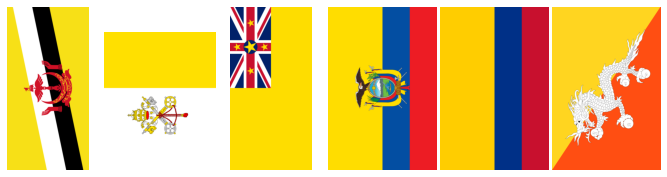

In [14]:
yellow_likeness_ranking = get_color_likeness_ranking(CMYK_flag_colors, color_percentages, [0.0, 0.0, 1.0, 0.0])
num_yellow_flags = 6
yellow_flags = [flags[i] for i in yellow_likeness_ranking[:num_yellow_flags]]
plot_flags(yellow_flags, rows=1, orientation='vertical')

filenames_sorted = [filenames[i] for i in yellow_likeness_ranking[:num_yellow_flags]]
for i, filename in enumerate(filenames_sorted):
    shutil.copyfile('svg_flags/' + filename + '.svg', 'svg_flags/Color/Yellow/' + str(i) + '_' + filename  + '.svg')

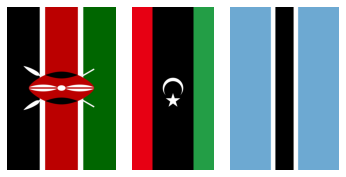

In [15]:
black_likeness_ranking = get_color_likeness_ranking(CMYK_flag_colors, color_percentages, [0.0, 0.0, 0.0, 1.0])
num_black_flags = 3
black_flags = [flags[i] for i in black_likeness_ranking[:num_black_flags]]
plot_flags(black_flags, rows=1, orientation='vertical')

### Tricolore

In [16]:
def get_tricolores(flags, flag_colors, color_percentages):
    is_tricolore = [False]*len(flag_colors)
    for i in range(len(flag_colors)):
        if sum(color_percentages[i] > 0.3) == 3 and 1020 in np.sum(flag_colors[i], axis=1):
            is_tricolore[i] = True
    return is_tricolore

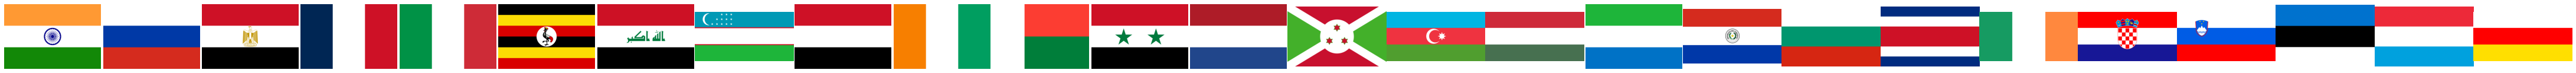

In [17]:
tricolores = get_tricolores(flags, flag_colors, color_percentages)
plot_flags([flag for i, flag in enumerate(flags) if tricolores[i]])

### Continent flag colors

In [18]:
def get_continent_flag_colors(flag_colors, color_percentages, continent_data, continent):
    country_idx = np.where(continent_data == continent)[0]
    flag_colors_continent = []
    color_percentages_continent = []
    for i in country_idx:
        for j in range(len(color_percentages[i])):
            if len(flag_colors_continent) == 0:
                flag_colors_continent.append(flag_colors[i][j])
                color_percentages_continent.append(color_percentages[i][j])
                continue
            deviation = np.linalg.norm(np.array(flag_colors_continent) - np.array(flag_colors[i][j]), axis=1)
            if np.min(deviation) > 0:
                flag_colors_continent.append(flag_colors[i][j])
                color_percentages_continent.append(color_percentages[i][j])
            else:
                pos = np.argmin(deviation)
                color_percentages_continent[pos] += color_percentages[i][j]
    return flag_colors_continent, color_percentages_continent / np.sum(color_percentages_continent)

In [19]:
flag_colors_continents = {}
color_percentages_continents = {}
for continent in ['Asia', 'Europe', 'Americas', 'Africa', 'Oceania']:
    flag_colors_continents[continent], color_percentages_continents[continent] = get_continent_flag_colors(flag_colors, color_percentages, df['Continent'], continent)
    #sorted_percentages = np.argsort(color_percentages_continents[continent])[::-1]
    sorted_percentages = np.array([x for _, x in sorted(zip(flag_colors_continents[continent], range(len(flag_colors_continents[continent]))), key=lambda pair: colorsys.rgb_to_hsv(*pair[0][:3]), reverse=True)])
    flag_colors_continents[continent] = [flag_colors_continents[continent][i] for i in sorted_percentages]
    color_percentages_continents[continent] = color_percentages_continents[continent][sorted_percentages]

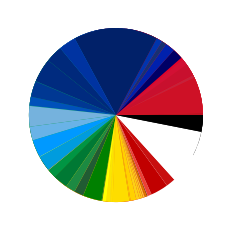

In [20]:
for continent in ['Asia', 'Europe', 'Americas', 'Africa', 'Oceania']:
    #plt.title(continent)
    plt.pie(color_percentages_continents[continent], colors=np.array(flag_colors_continents[continent])/255)
    plt.savefig(continent + '_flag_colors.svg', format='svg')

### Populaton

In [41]:
def str_to_int(str):
    return int(str.replace(',', ''))

In [46]:
max_height = 20
for i, filename in enumerate(filenames[:20]):
    ratio = str_to_int(df['Population'][i]) / str_to_int(df['Population'][0]) * max_height
    shutil.copyfile('svg_flags/' + filename  + '.svg', 'svg_flags/Population/' + str(round(ratio, 3)) + filename  + '.svg')

### Square flag layouts

In [55]:
for i in range(len(df)):
    if int(df['Width'][i]) / int(df['Height'][i]) < 5/4 + 0.00001 :
        shutil.copyfile('svg_flags/' + filenames[i]  + '.svg', 'svg_flags/Layout/Square/' + filenames[i]  + '.svg')

### Flag colors of the world

In [63]:
flag_colors_world, color_percentages_world = get_continent_flag_colors(flag_colors, color_percentages, np.ones(len(flag_colors)), 1)
#sorted_percentages = np.argsort(color_percentages_continents[continent])[::-1]
sorted_percentages = np.array([x for _, x in sorted(zip(flag_colors_world, range(len(flag_colors_world))), key=lambda pair: colorsys.rgb_to_hsv(*pair[0][:3]), reverse=True)])
flag_colors_world = [flag_colors_world[i] for i in sorted_percentages]
color_percentages_world = color_percentages_world[sorted_percentages]

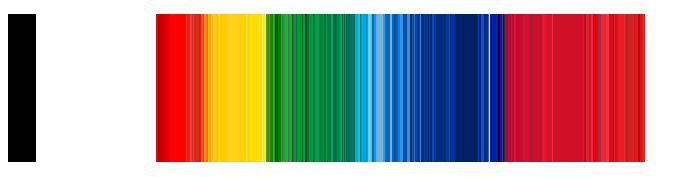

In [65]:
bottom = 1
width = 1

fig, ax = plt.subplots(figsize=(12, 3))
ax.axis('off')

for percentage, color in zip(color_percentages_world, flag_colors_world):
    bottom -= percentage
    bc = ax.barh(0, percentage, width, left=bottom, color=np.array(color)/255)

#plt.show()
plt.savefig('world_flag_colors.svg', format='svg')

In [82]:
for i in range(len(df)):
    if abs(int(df['Width'][i]) / int(df['Height'][i]) - 3/2) < 0.001:
        shutil.copyfile('svg_flags/' + filenames[i]  + '.svg', 'svg_flags/Layout/3by2_complexity/' + str(round(complexities[i], 2)) + '_' + filenames[i]  + '.svg')